# 機率校準

問一個問題如果你再做一個二分類問題，假設是正或負兩類，
然後你的模型對某個 sample 輸出預測 $0.8$ ，
你會認為他是正類的機率是 $80%$ 嗎?


答案是，如果你沒有經過校準，那是錯誤的。

## 動機

如果你只是要做圖片分類等等的問題，那你可能只會在意選什麼閥值就好，
但是如果你今天要做的是風險分析，或是給出預測報告，
你就會希望給出的是一個正確的機率。



## Calibration Curve

訓練好一個模型以後，有些模型可以給出機率預測 ``predict_proba``，
有一些模型沒有只提供 ``decision_function``，你可以使用

$$
\frac{score - \min (score)}{\max (score) - \min (score)}
$$

縮放到 $[0, 1]$ 區間，
然後考慮 x 軸放 預測的平均， y 軸放 真實的正例的比例，
這樣我們就可以知道誤差有多少。


下面看一個 ``calibration_curve`` 的使用範例。


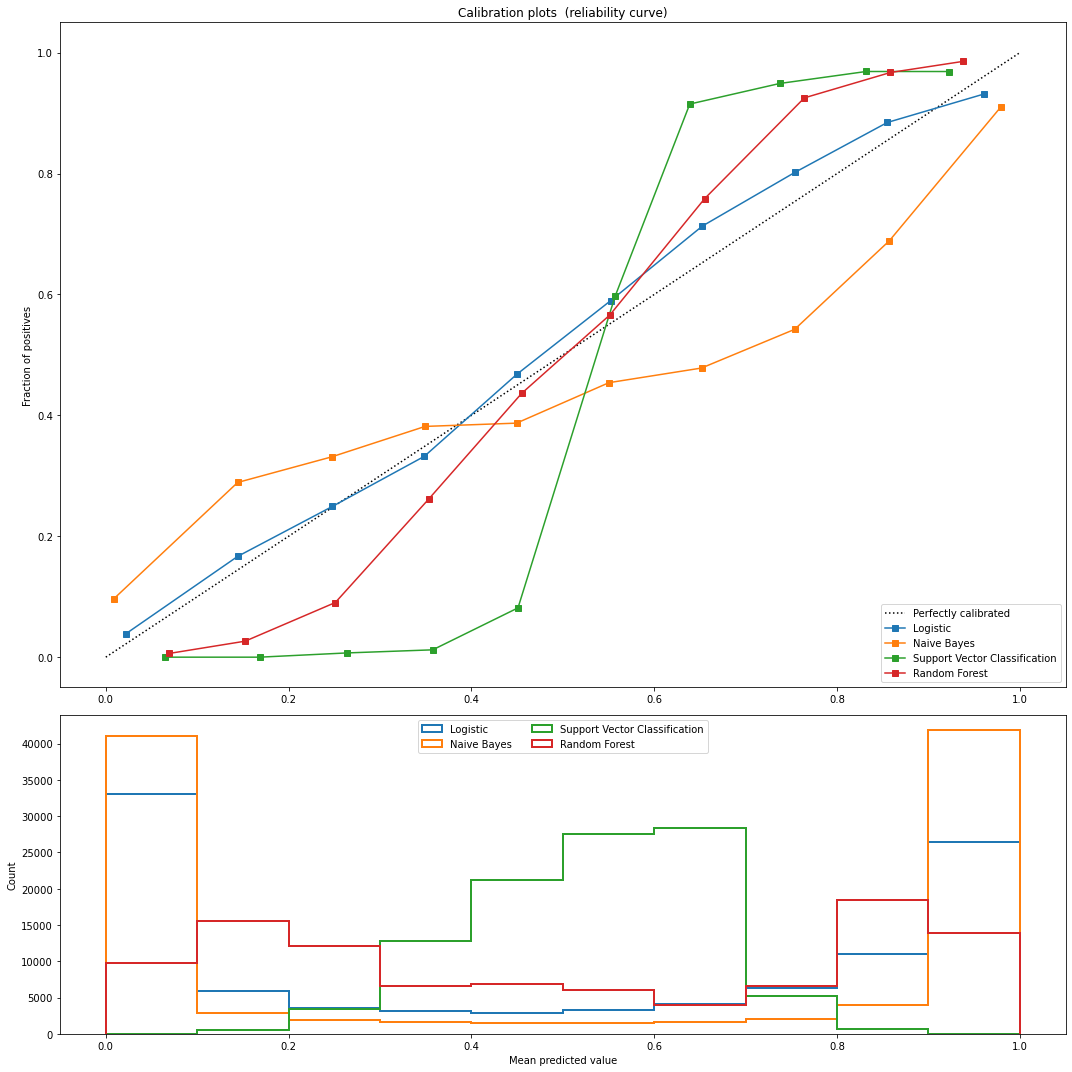

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

np.random.seed(5087)
X, y = datasets.make_classification(n_samples=100000, 
                                    n_features=20,
                                    n_informative=2, 
                                    n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train, X_test = X[:train_samples], X[train_samples:]
y_train, y_test = y[:train_samples], y[train_samples:]

# Create classifiers
classifier_lr  = LogisticRegression().fit(X_train, y_train)
classifier_gnb = GaussianNB().fit(X_train, y_train)
classifier_svc = LinearSVC(C=1.0).fit(X_train, y_train)
classifier_rfc = RandomForestClassifier().fit(X_train, y_train)

# Plot calibration plots

plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for classifier, name in [(classifier_lr, 'Logistic'),
                         (classifier_gnb, 'Naive Bayes'),
                         (classifier_svc, 'Support Vector Classification'),
                         (classifier_rfc, 'Random Forest')]:
    
    if hasattr(classifier, "predict_proba"):
        prob_pos = classifier.predict_proba(X_test)[:, 1]
    else:  # use decision function
        decision_score = classifier.decision_function(X_test)
        prob_pos = (decision_score - decision_score.min()) / (decision_score.max() - decision_score.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

如果你還是不太清楚下面去到[程式](https://github.com/scikit-learn/scikit-learn/blob/f3f51f9b6/sklearn/calibration.py#L873)裡面來看。


![calibration curve](https://github.com/tobytoy/OpenResource/raw/main/machine-learning(scikit-learn)/images/scikit-learn_calibration.jpg)


下面給一個範例


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

np.random.seed(5087)
train_samples = 100
X, y = datasets.make_classification(n_samples=(train_samples*2), 
                                    n_features=20,
                                    n_informative=2, 
                                    n_redundant=2)

X_train, X_test = X[:train_samples], X[train_samples:]
y_train, y_test = y[:train_samples], y[train_samples:]
prob_pos        = LogisticRegression().fit(X_train, y_train).predict_proba(X_test)[:, 1]


bins = np.linspace(0.0, 1.0, 10 + 1)     
print('bins: ', bins)               # 要分成幾份
binids = np.searchsorted(bins[1:-1], prob_pos)     
print('binids: ', binids)           # 把機率分到該去的那個 bins
bin_sums = np.bincount(binids, weights=prob_pos, minlength=len(bins))  
print('bin_sums: ', bin_sums)       # 每個 bin 區間的預測資料合
bin_true = np.bincount(binids, weights=y_test, minlength=len(bins))     
print('bin_true: ', bin_true)       # 每個 bin 區間的真實 positive 的數量
bin_total = np.bincount(binids, minlength=len(bins))        # 每個 bin 裡面有多少 data

nonzero = bin_total != 0
prob_true = bin_true[nonzero] / bin_total[nonzero]
print('prob_true: ', prob_true)       # 每個 bin 區間的真實 positive 的機率
prob_pred = bin_sums[nonzero] / bin_total[nonzero]
print('prob_pred: ', prob_pred)       # 每個 bin 區間的預測資料平均

bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
binids:  [9 0 5 9 8 9 1 7 9 0 8 7 8 0 0 0 8 9 0 9 0 3 4 8 0 4 9 9 9 0 2 0 8 1 6 4 0
 6 9 9 9 0 3 9 2 9 3 1 9 0 1 9 9 4 0 9 0 1 9 6 3 8 0 0 0 9 8 5 9 8 8 4 3 1
 1 8 9 9 2 9 0 1 2 1 2 0 1 9 0 9 4 0 3 9 9 3 0 0 9 1]
bin_sums:  [ 0.96912251  1.37432812  1.20987175  2.47447781  2.61664952  1.11192513
  1.84976809  1.52771945  9.48038664 28.29918874  0.        ]
bin_true:  [ 3.  3.  0.  0.  2.  0.  1.  1.  9. 28.  0.]
prob_true:  [0.125      0.27272727 0.         0.         0.33333333 0.
 0.33333333 0.5        0.81818182 0.96551724]
prob_pred:  [0.0403801  0.12493892 0.24197435 0.35349683 0.43610825 0.55596256
 0.61658936 0.76385973 0.86185333 0.97583409]
